In [1]:
import torch
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from open_clip import build_zero_shot_classifier, MonoCLIP
import cv2
seed_value = 42
torch.manual_seed(seed_value)
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用第一个 GPU

print(torch.cuda.is_available())
print(torch.version.cuda)



True
12.1


/home/xuq1mu/anaconda3/envs/clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_person_scoremap(img, model, cls):
    image = model.preprocess(img)
    
    input = image.to("cuda").unsqueeze(0)
    class_conf = model(input)
    class_conf = (class_conf / 1e-2).softmax(dim=1)
    
    class_conf_np = class_conf.squeeze().cpu().detach().numpy()

    img = input.squeeze(0)
    img_np = img.permute(1, 2, 0).cpu().numpy()

    img_np = np.clip(img_np, 0, 1)
    class_conf_np_cls = class_conf_np[cls]
    class_conf_np_cls = np.clip(class_conf_np_cls, 0, 1) # score map for person
    resized_conf = cv2.resize(class_conf_np_cls, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_LINEAR)
    mask = np.argmax(class_conf_np, axis=0)
    
    return img_np, resized_conf, mask

In [3]:
coco_cls=['person and human', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'analog clock, digital clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# coco_cls=['person and human', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'analog clock, digital clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
background_cls = ['deer', 'fixed-line telephone', 'rubbish bin', 'plate', 'sky', 'water', 'road', 'grass', 'sand', 'snow', 'building', 'tree', ]

coco_cls_refine=['person and human', 'animal', 'vehicle', 'traffic light and street light', 'household items', 'electronics', 'building', 'sky', 'ground', 'water']

model = MonoCLIP(data_class=coco_cls_refine).to("cuda")

img_person_0 = Image.open("./data/person_5.jpg")
img_person_1 = Image.open("./data/person_2.jpg")
img_person_2 = Image.open("./data/person_0.jpg")

model.preprocess.transforms.pop(0)
model.preprocess.transforms.pop(0)

img_np_person_0, resized_conf_person_0, mask_0 = get_person_scoremap(img_person_0, model, 0)
img_np_person_1, resized_conf_person_1, mask_1 = get_person_scoremap(img_person_1, model, 0)
img_np_person_2, resized_conf_person_2, mask_2 = get_person_scoremap(img_person_2, model, 0)

img_np_person_0, resized_conf_background_0, mask_0 = get_person_scoremap(img_person_0, model, 4)
img_np_person_1, resized_conf_background_1, mask_1 = get_person_scoremap(img_person_1, model, -1)
img_np_person_2, resized_conf_background_2, mask_2 = get_person_scoremap(img_person_2, model, -3)

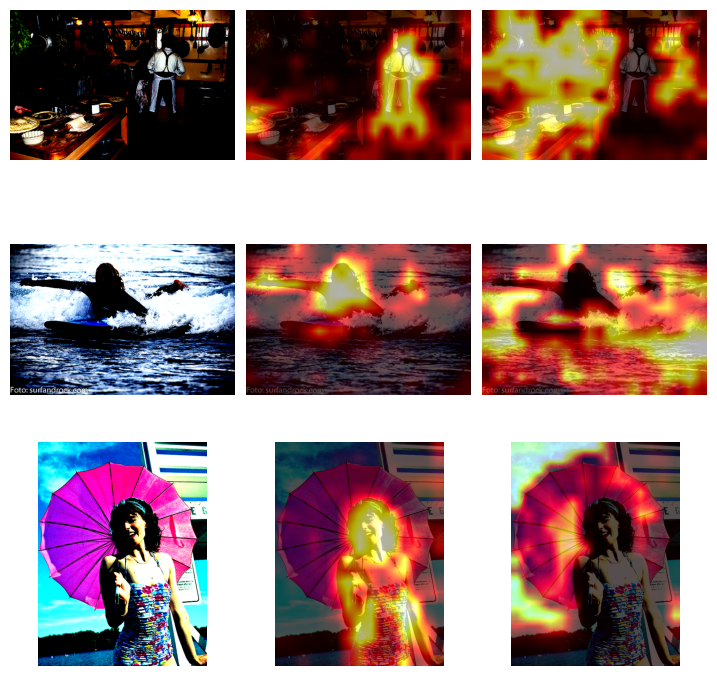

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

axs[0,0].imshow(img_np_person_0)
axs[0,1].imshow(img_np_person_0)
axs[0,1].imshow(resized_conf_person_0, cmap="hot", alpha=0.7)
axs[0,2].imshow(img_np_person_0)
axs[0,2].imshow(resized_conf_background_0, cmap="hot", alpha=0.7)


axs[1,0].imshow(img_np_person_1)
axs[1,1].imshow(img_np_person_1)
axs[1,1].imshow(resized_conf_person_1, cmap="hot", alpha=0.7)
axs[1,2].imshow(img_np_person_1)
axs[1,2].imshow(resized_conf_background_1, cmap="hot", alpha=0.7)


axs[2, 0].imshow(img_np_person_2)
axs[2, 1].imshow(img_np_person_2)
axs[2, 1].imshow(resized_conf_person_2, cmap="hot", alpha=0.7)
axs[2, 2].imshow(img_np_person_2)
axs[2, 2].imshow(resized_conf_background_2, cmap="hot", alpha=0.7)


# 移除每个子图的坐标轴
for ax in axs.flat:
    ax.axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

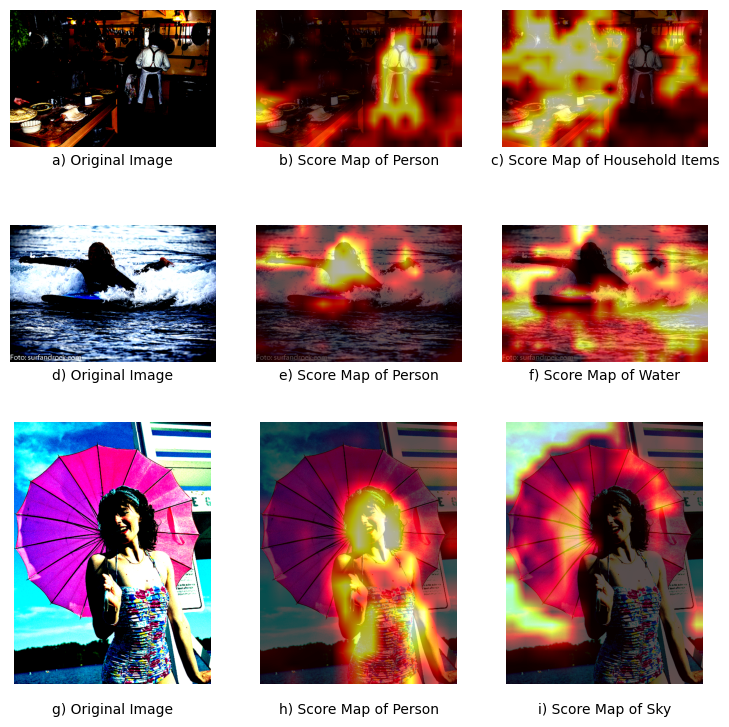

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 示例数据和形状调整
import numpy as np

# 创建一个 GridSpec 对象来控制每行的高度比例
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1.5], hspace=0.2, wspace=0.2)

# 第一行
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow(img_np_person_0)
ax1.text(0.5, -0.1, 'a) Original Image', ha='center', va='center', transform=ax1.transAxes)

ax2.imshow(img_np_person_0)
ax2.imshow(resized_conf_person_0, cmap="hot", alpha=0.7)
ax2.text(0.5, -0.1, 'b) Score Map of Person', ha='center', va='center', transform=ax2.transAxes)

ax3.imshow(img_np_person_0)
ax3.imshow(resized_conf_background_0, cmap="hot", alpha=0.7)
ax3.text(0.5, -0.1, 'c) Score Map of Household Items', ha='center', va='center', transform=ax3.transAxes)

# 第二行
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

ax4.imshow(img_np_person_1)
ax4.text(0.5, -0.1, 'd) Original Image', ha='center', va='center', transform=ax4.transAxes)

ax5.imshow(img_np_person_1)
ax5.imshow(resized_conf_person_1, cmap="hot", alpha=0.7)
ax5.text(0.5, -0.1, 'e) Score Map of Person', ha='center', va='center', transform=ax5.transAxes)

ax6.imshow(img_np_person_1)
ax6.imshow(resized_conf_background_1, cmap="hot", alpha=0.7)
ax6.text(0.5, -0.1, 'f) Score Map of Water', ha='center', va='center', transform=ax6.transAxes)

# 第三行
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

ax7.imshow(img_np_person_2)
ax7.text(0.5, -0.1, 'g) Original Image', ha='center', va='center', transform=ax7.transAxes)

ax8.imshow(img_np_person_2)
ax8.imshow(resized_conf_person_2, cmap="hot", alpha=0.7)
ax8.text(0.5, -0.1, 'h) Score Map of Person', ha='center', va='center', transform=ax8.transAxes)

ax9.imshow(img_np_person_2)
ax9.imshow(resized_conf_background_2, cmap="hot", alpha=0.7)
ax9.text(0.5, -0.1, 'i) Score Map of Sky', ha='center', va='center', transform=ax9.transAxes)


# 移除每个子图的坐标轴
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.axis('off')

plt.show()
